In [20]:
import numpy as np
import cv2

# Q2
Read `LineDetection.jpg` (the image below)




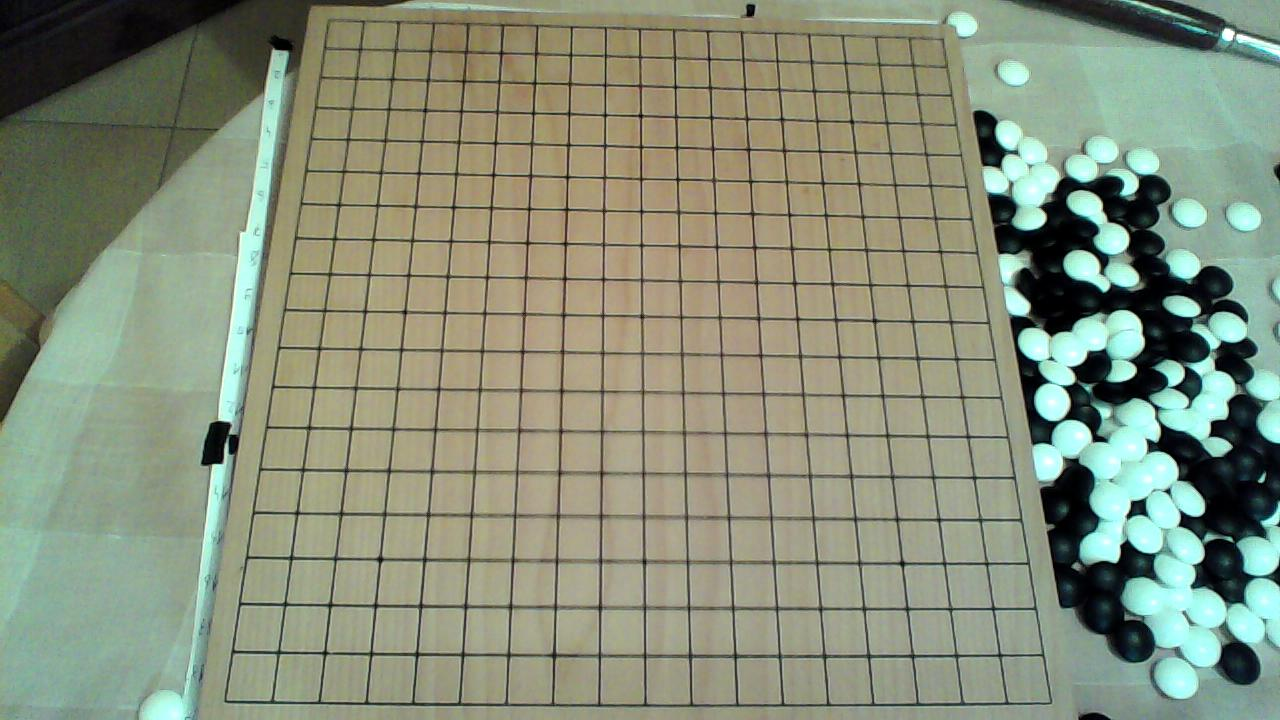

Use Hough to detect lines.

Note that you should consider the `Threshold`!

Here the threshold is `250`


True

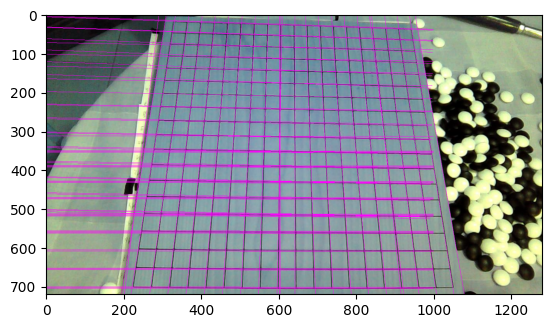

In [4]:
#https://www.geeksforgeeks.org/line-detection-python-opencv-houghline-method/#:~:text=The%20Hough%20Transform%20is%20a,or%20distorted%20a%20little%20bit.
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('LineDetection.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi/180, 250)
 
for r_theta in lines:
    arr = np.array(r_theta[0], dtype=np.float64)
    r, theta = arr
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*r
    y0 = b*r
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img, (x1, y1), (x2, y2), (255, 0, 255), 1)
plt.imshow(img)
cv2.imwrite('linesDetected.jpg', img)

Here is a sample output:

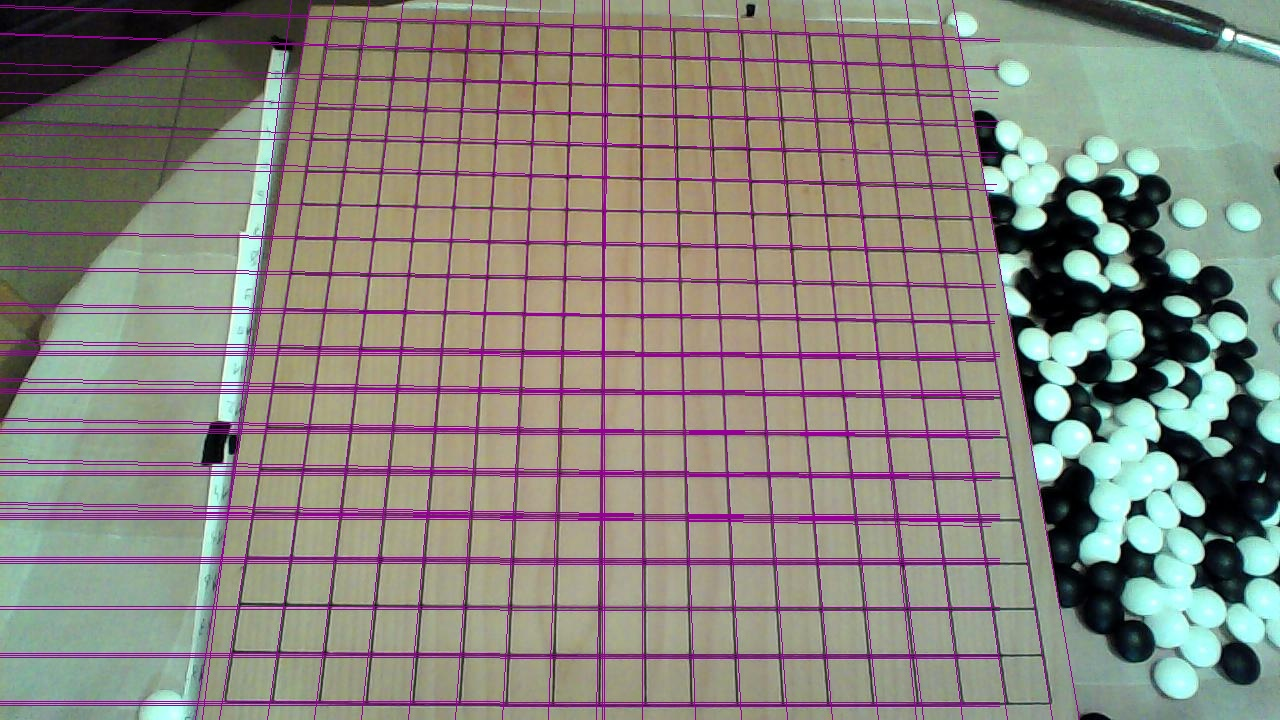

Now use *Probabilistic Hough Transform*. then, apply it to this picture.

True

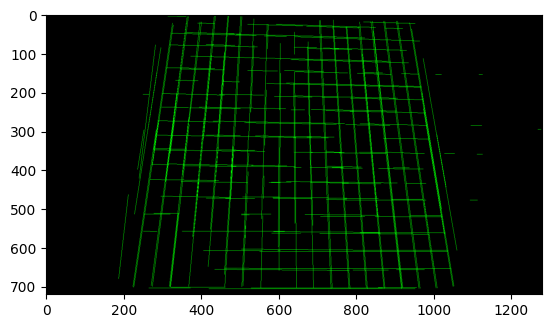

In [98]:
#TODO

import cv2
import numpy as np
import matplotlib.pyplot as plt


image = cv2.imread('LineDetection.jpg')
blank_image = np.zeros((image.shape[0],image.shape[1],3), np.uint8)
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,150,150,apertureSize=3)
 
lines_list =[]
lines = cv2.HoughLinesP(edges, 1, np.pi/360,threshold=140,minLineLength=5, maxLineGap=15)
 
for points in lines:
    x1,y1,x2,y2=points[0]
    cv2.line(image,(x1,y1),(x2,y2),(0,255,0),1)
    cv2.line(blank_image,(x1,y1),(x2,y2),(0,255,0),1)
    lines_list.append([(x1,y1),(x2,y2)])
     
plt.imshow(blank_image)
cv2.imwrite('linesDetected_Probabilistic.jpg', image)

Here is a sample output (Not the best one): 

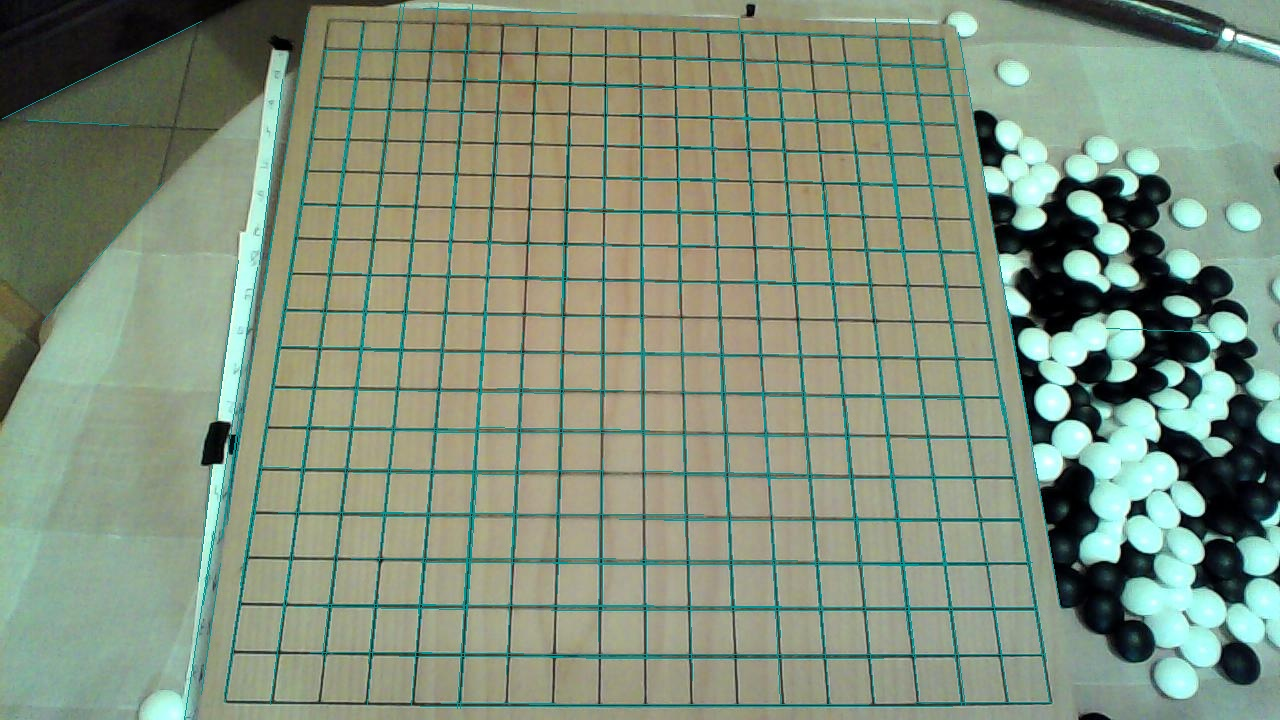

Note that you should find the optimum amount of parameters which are used in this algorithm.

C:\Users\mousa\AppData\Local\Temp\ipykernel_5788\4220734895.py:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(imgpath)


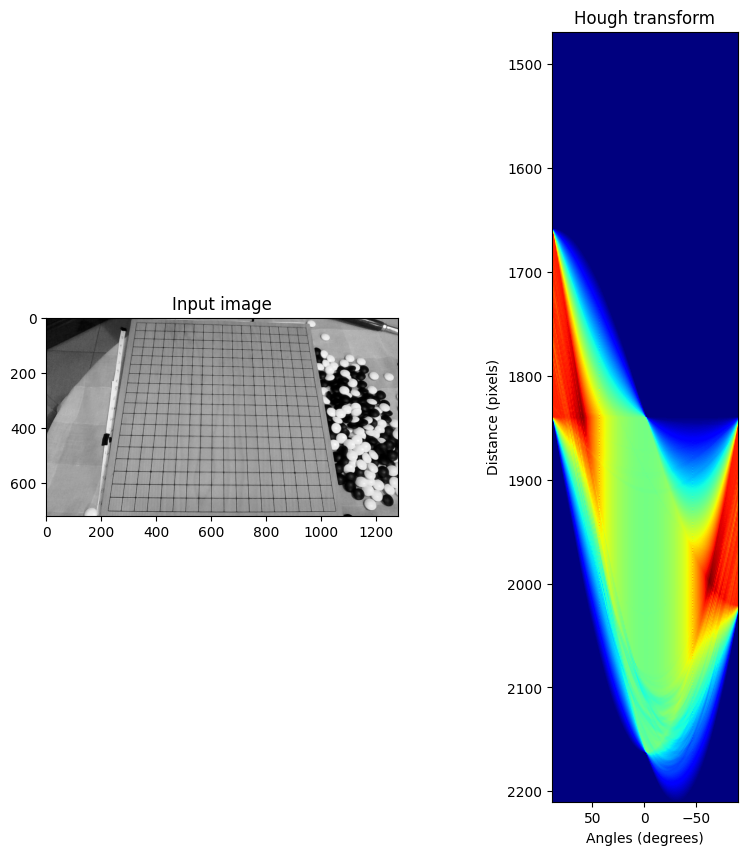

In [3]:
import numpy as np
import imageio
import math

def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114]).astype(np.uint8)


def hough_line(img, angle_step=1, lines_are_white=True, value_threshold=5):

    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    # (row, col) indexes to edges
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    y_idxs, x_idxs = np.nonzero(are_edges)

    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]

        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos

def fast_hough_line(img, angle_step=1, lines_are_white=True, value_threshold=5):
    """hough line using vectorized numpy operations,
    may take more memory, but takes much less time"""
    # Rho and Theta ranges
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step)) #can be changed
    #width, height = col.size  #if we use pillow
    width, height = img.shape
    diag_len = int(np.ceil(np.sqrt(width * width + height * height)))   # max_dist
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    # Cache some resuable values
    cos_theta = np.cos(thetas)
    sin_theta = np.sin(thetas)
    num_thetas = len(thetas)
    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((2 * diag_len, num_thetas))
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    #are_edges = cv2.Canny(img,50,150,apertureSize = 3)
    y_idxs, x_idxs = np.nonzero(are_edges)  # (row, col) indexes to edges
    # Vote in the hough accumulator
    xcosthetas = np.dot(x_idxs.reshape((-1,1)), cos_theta.reshape((1,-1)))
    ysinthetas = np.dot(y_idxs.reshape((-1,1)), sin_theta.reshape((1,-1)))
    rhosmat = np.round(xcosthetas + ysinthetas) + diag_len
    rhosmat = rhosmat.astype(np.int16)
    for i in range(num_thetas):
        rhos,counts = np.unique(rhosmat[:,i], return_counts=True)
        accumulator[rhos,i] = counts
    return accumulator, thetas, rhos

def show_hough_line(img, accumulator, thetas, rhos, save_path=None):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Input image')
    ax[0].axis('image')

    ax[1].imshow(
        accumulator, cmap='jet',
        extent=[np.rad2deg(thetas[-1]), np.rad2deg(thetas[0]), rhos[-1], rhos[0]])
    ax[1].set_aspect('equal', adjustable='box')
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')
    ax[1].axis('image')

    # plt.axis('off')
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()


if __name__ == '__main__':
    imgpath = "F:/university/Machine vision/HW[6]/LineDetection.jpg"
    img = imageio.imread(imgpath)
    if img.ndim == 3:
        img = rgb2gray(img)
    accumulator, thetas, rhos = fast_hough_line(img)
    show_hough_line(img, accumulator, thetas, rhos, save_path='F:/university/Machine vision/HW[6]/output.png')

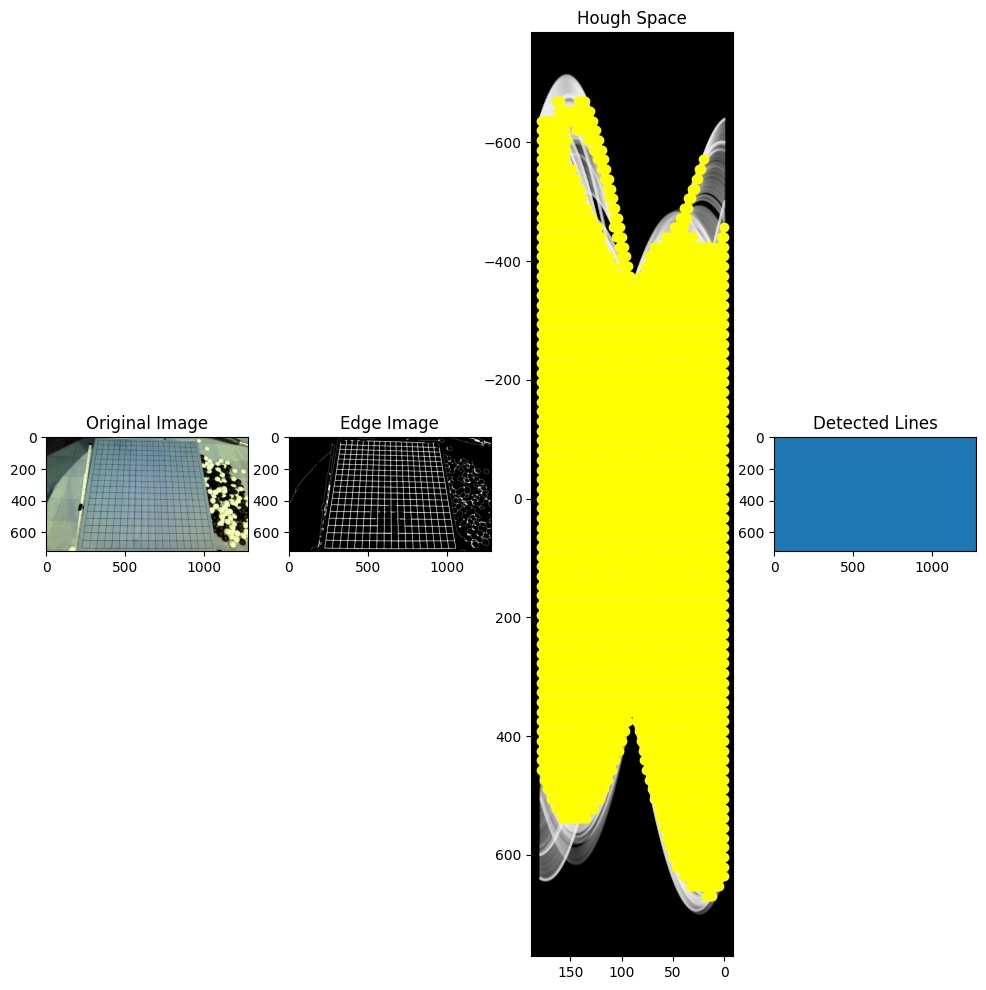

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


def line_detection_non_vectorized(image, edge_image, num_rhos=180, num_thetas=180, t_count=200):
  lines_list = []
  edge_height, edge_width = edge_image.shape[:2]
  edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
  #
  d = np.sqrt(np.square(edge_height) + np.square(edge_width))
  dtheta = 180 / num_thetas
  drho = (2 * d) / num_rhos
  #
  thetas = np.arange(0, 180, step=dtheta)
  rhos = np.arange(-d, d, step=drho)
  #
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  #
  accumulator = np.zeros((len(rhos), len(rhos)))
  #
  figure = plt.figure(figsize=(12, 12))
  subplot1 = figure.add_subplot(1, 4, 1)
  subplot1.imshow(image)
  subplot2 = figure.add_subplot(1, 4, 2)
  subplot2.imshow(edge_image, cmap="gray")
  subplot3 = figure.add_subplot(1, 4, 3)
  subplot3.set_facecolor((0, 0, 0))
  subplot4 = figure.add_subplot(1, 4, 4)
  subplot4.imshow(image)
  #
  for y in range(edge_height):
    for x in range(edge_width):
      if edge_image[y][x] != 0:
        edge_point = [y - edge_height_half, x - edge_width_half]
        ys, xs = [], []
        for theta_idx in range(len(thetas)):
          rho = (edge_point[1] * cos_thetas[theta_idx]) + (edge_point[0] * sin_thetas[theta_idx])
          theta = thetas[theta_idx]
          rho_idx = np.argmin(np.abs(rhos - rho))
          accumulator[rho_idx][theta_idx] += 1
          ys.append(rho)
          xs.append(theta)
        subplot3.plot(xs, ys, color="white", alpha=0.05)

  for y in range(accumulator.shape[0]):
    for x in range(accumulator.shape[1]):
      if accumulator[y][x] > t_count:
        rho = rhos[y]
        theta = thetas[x]
        a = np.cos(np.deg2rad(theta))
        b = np.sin(np.deg2rad(theta))
        x0 = (a * rho) + edge_width_half
        y0 = (b * rho) + edge_height_half
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        subplot3.plot([theta], [rho], marker='o', color="yellow")
        subplot4.add_line(mlines.Line2D([x1, x2], [y1, y2]))
        cv2.line(image_hold,(x1,y1),(x2,y2),(0,255,0),1)

  subplot3.invert_yaxis()
  subplot3.invert_xaxis()

  subplot1.title.set_text("Original Image")
  subplot2.title.set_text("Edge Image")
  subplot3.title.set_text("Hough Space")
  subplot4.title.set_text("Detected Lines")
  plt.show()
  return accumulator, rhos, thetas


if __name__ == "__main__":
  for i in range(1):
    image= cv2.imread('LineDetection.jpg')
    image_hold= cv2.imread('LineDetection.jpg')
    edge_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
    edge_image = cv2.Canny(edge_image, 100, 200)
    edge_image = cv2.dilate(
        edge_image,
        cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)),
        iterations=1
    )
    edge_image = cv2.erode(
        edge_image,
        cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)),
        iterations=1
    )
    line_detection_non_vectorized(image, edge_image)

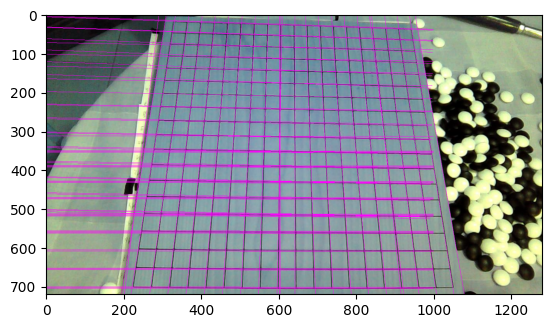

In [5]:
plt.imshow(img)

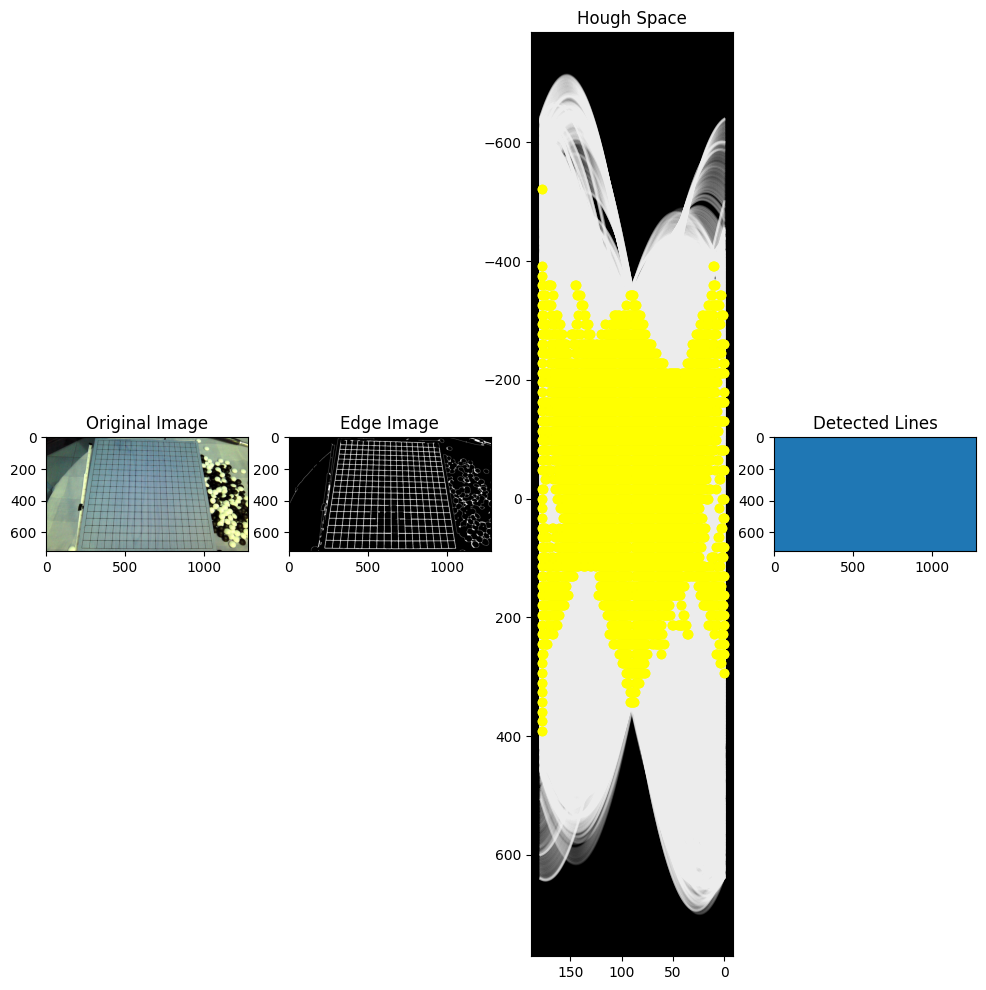

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


def line_detection_vectorized(image, edge_image, num_rhos=180, num_thetas=180, t_count=2200):
  edge_height, edge_width = edge_image.shape[:2]
  edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
  #
  d = np.sqrt(np.square(edge_height) + np.square(edge_width))
  dtheta = 180 / num_thetas
  drho = (2 * d) / num_rhos
  #
  thetas = np.arange(0, 180, step=dtheta)
  rhos = np.arange(-d, d, step=drho)
  #
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  #
  accumulator = np.zeros((len(rhos), len(rhos)))
  #
  figure = plt.figure(figsize=(12, 12))
  subplot1 = figure.add_subplot(1, 4, 1)
  subplot1.imshow(image)
  subplot2 = figure.add_subplot(1, 4, 2)
  subplot2.imshow(edge_image, cmap="gray")
  subplot3 = figure.add_subplot(1, 4, 3)
  subplot3.set_facecolor((0, 0, 0))
  subplot4 = figure.add_subplot(1, 4, 4)
  subplot4.imshow(image)
  #
  edge_points = np.argwhere(edge_image != 0)
  edge_points = edge_points - np.array([[edge_height_half, edge_width_half]])
  #
  rho_values = np.matmul(edge_points, np.array([sin_thetas, cos_thetas]))
  #
  accumulator, theta_vals, rho_vals = np.histogram2d(
      np.tile(thetas, rho_values.shape[0]),
      rho_values.ravel(),
      bins=[thetas, rhos]
  )
  accumulator = np.transpose(accumulator)
  lines = np.argwhere(accumulator > t_count)
  rho_idxs, theta_idxs = lines[:, 0], lines[:, 1]
  r, t = rhos[rho_idxs], thetas[theta_idxs]

  for ys in rho_values:
    subplot3.plot(thetas, ys, color="white", alpha=0.05)

  subplot3.plot([t], [r], color="yellow", marker='o')

  for line in lines:
    y, x = line
    rho = rhos[y]
    theta = thetas[x]
    a = np.cos(np.deg2rad(theta))
    b = np.sin(np.deg2rad(theta))
    x0 = (a * rho) + edge_width_half
    y0 = (b * rho) + edge_height_half
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    subplot3.plot([theta], [rho], marker='o', color="yellow")
    subplot4.add_line(mlines.Line2D([x1, x2], [y1, y2]))
    cv2.line(image_hold,(x1,y1),(x2,y2),(0,255,0),1)

  subplot3.invert_yaxis()
  subplot3.invert_xaxis()

  subplot1.title.set_text("Original Image")
  subplot2.title.set_text("Edge Image")
  subplot3.title.set_text("Hough Space")
  subplot4.title.set_text("Detected Lines")
  plt.show()
  return accumulator, rhos, thetas


if __name__ == "__main__":
  for i in range(1):
    image= cv2.imread('LineDetection.jpg')
    image_hold= cv2.imread('LineDetection.jpg')
    edge_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edge_image = cv2.GaussianBlur(edge_image, (3, 3), 1)
    edge_image = cv2.Canny(edge_image, 100, 200)
    edge_image = cv2.dilate(
        edge_image,
        cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)),
        iterations=1
    )
    edge_image = cv2.erode(
        edge_image,
        cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)),
        iterations=1
    )
    line_detection_vectorized(image, edge_image)

# Q3

What does this cell of code do? Explain the algorithm.

Then Compare it with the results of the previous part.

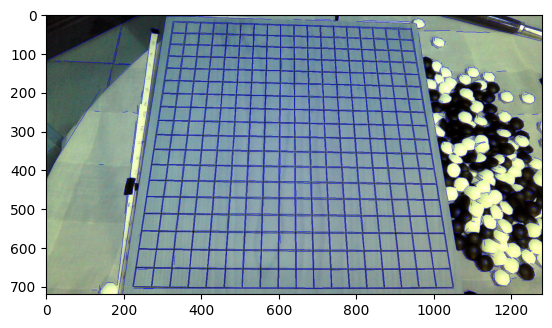

In [8]:
img = cv2.imread("LineDetection.jpg",0)
imgcolorous = cv2.imread('LineDetection.jpg')
UNKNOWN = cv2.createLineSegmentDetector(0)
lines = UNKNOWN.detect(img)[0]
drawn_img = UNKNOWN.drawSegments(imgcolorous,lines)
plt.imshow(drawn_img)

# Q4

In the cells below you should define two functions that one of them covert RGB to CMYK and another one Convert them vice versa. 

In [2]:
def rgb_to_cmyk(r, g, b, RGB_SCALE = 255, CMYK_SCALE = 100):

  #TODO
  if (r, g, b) == (0, 0, 0):
        return 0, 0, 0, CMYK_SCALE

  c = 1 - r / RGB_SCALE
  m = 1 - g / RGB_SCALE
  y = 1 - b / RGB_SCALE

  min_cmy = min(c, m, y)
  c = (c - min_cmy) / (1 - min_cmy)
  m = (m - min_cmy) / (1 - min_cmy)
  y = (y - min_cmy) / (1 - min_cmy)
  k = min_cmy

  c = c * CMYK_SCALE
  m = m * CMYK_SCALE
  y = y * CMYK_SCALE
  k = k * CMYK_SCALE
  return c, m, y, k

In [3]:
rgb_to_cmyk(25, 56, 25)

(55.35714285714286, 0.0, 55.35714285714286, 78.03921568627452)

Expected Output: (55, 0, 55, 78)

In [4]:
def cmyk_to_rgb(c, m, y, k, CMYK_SCALE = 100, RGB_SCALE = 255):

  #TODO
  r = RGB_SCALE * (1.0 - c / float(CMYK_SCALE)) * (1.0 - k / float(CMYK_SCALE))
  g = RGB_SCALE * (1.0 - m / float(CMYK_SCALE)) * (1.0 - k / float(CMYK_SCALE))
  b = RGB_SCALE * (1.0 - y / float(CMYK_SCALE)) * (1.0 - k / float(CMYK_SCALE))

  return r, g, b

In [5]:
cmyk_to_rgb(55, 0, 55, 78)

(25.244999999999994, 56.099999999999994, 25.244999999999994)

Expected Output: (25, 56, 25)

# Q5
Compute the HSI parametes and V, L and Y according to lectures.

In [14]:
#TODO 
import numpy as np
def HSI(r,g,b):
    theta = np.arccos(((r-g)+(r-b))/(2*np.sqrt(((r-g)**2)+(r-b)*(g-b))))
    if b<=g:
        H = theta
    else:
        H = 360 - theta
    S = 1 - 3*((min(r,g,b))/(r+g+b))
    I = (r+g+b)/3
    print("H:{}, S:{}, I:{}".format(H,S,I))
    
def HSV(r,g,b):
    V = max(r,g,b)
    L = (max(r,g,b)+min(r,g,b))/2
    print("V:{}, L:{}".format(V,L))
def ycbcr(r,g,b):
    y = 16 + (((r<<6)+(r<<1)+(g<<7)+g+(b<<4)+(b<<3)+b)>>8)
    Cb = 128+((-((r<<5)+(r<<2)+(r<<1))-((g<<6)+(g<<3)+(g<<1))+((b<<7)-(b<<4)))>>8)
    Cr = 128+(((r<<7)-(r<<4)-((g<<6)+(g<<5)-(g<<1))-((b<<4)+(b<<1)))>>8)
    print("y:{}, Cb:{}, Cr:{}".format(y,Cb,Cr))

(r,g,b) = (150, 65, 200) 
HSI(r,g,b)
HSV(r,g,b)
ycbcr(r,g,b)


H:358.5777839762459, S:0.5301204819277108, I:138.33333333333334
V:200, L:132.5
y:106, Cb:174, Cr:155


# Good Luck!